In [21]:
import numpy as np
import glob
import random
import imageio
import PIL, cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
import skimage as si
import math
from scipy.ndimage.filters import convolve
from PIL import Image,ImageFilter
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

C:\Users\klaud\AppData\Local\Temp\ipykernel_9732\3224726410.py:13: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


# Import images


In [4]:
DATA_DIR = "./Real/"
images = glob.glob(DATA_DIR + "*.BMP")

#count images
print(len(images))

6000


(103, 96, 3)
(103, 96, 3)


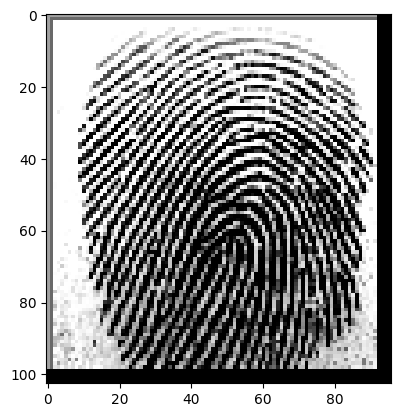

In [31]:
image1 = cv2.imread(images[0], cv2.COLOR_BGR2GRAY)
image2 = cv2.imread(images[2999], cv2.COLOR_BGR2GRAY)
image3 = cv2.imread(images[5999], cv2.COLOR_BGR2GRAY)
test1 = si.color.rgb2gray(image1)
print(np.shape(image1))
print(np.shape(image1))
pltImage1 = plt.imshow(image1)



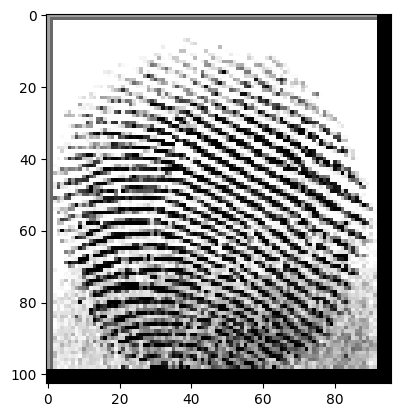

In [32]:
pltImage2 = plt.imshow(image2)


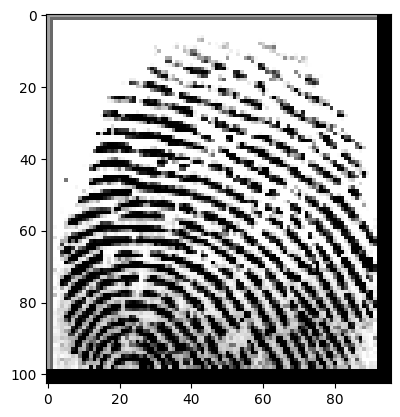

In [33]:
pltImage3 = plt.imshow(image3)

[[192 192 192 ...   0   0   0]
 [192   0   0 ...   0   0   0]
 [192   0 192 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
[[[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  ...
  [False False False]
  [False False False]
  [False False False]]

 [[ True  True  True]
  [False False False]
  [False False False]
  ...
  [False False False]
  [False False False]
  [False False False]]

 [[ True  True  True]
  [False False False]
  [ True  True  True]
  ...
  [False False False]
  [False False False]
  [False False False]]

 ...

 [[False False False]
  [False False False]
  [False False False]
  ...
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ...
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ...
  [False False False]
  [False

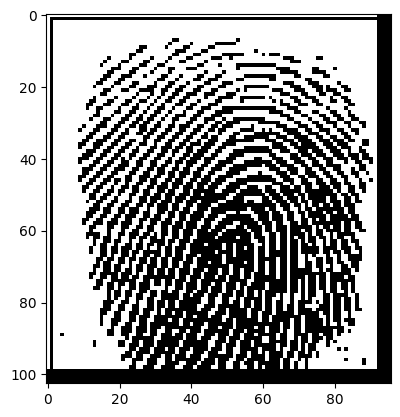

In [40]:
img1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
plt.imshow(img1_gray)
th, im_gray_th_otsu = cv2.threshold(img1_gray, 128, 192, cv2.THRESH_OTSU)
thresh = 128

im_bool = image1 > thresh
plt.imshow(im_gray_th_otsu)
print(im_gray_th_otsu)
print(im_bool)

maxval = 255

im_bin = (image1 > thresh) * maxval
print(im_bin)
plt.imshow(im_bin)